# 📔 About this notebook

PetFinder.my - Pawpularity Contest



## 📝 Memo

- transformer の output と feature を SVR で学習する。
    - NN の head と SVR でアンサンブルする。 [Link](https://www.kaggle.com/cdeotte/rapids-svr-boost-17-8/notebook)
- swin base, large と CSWin と B7 でアンサンブル。
- ConvMixer [Link](https://github.com/tmp-iclr/convmixer)

# 📚 Library

In [1]:
# General libraries
import collections
import gc
import glob
import json
import math
import os
import pickle
import random
import re
import statistics
import sys
import time
import warnings
from contextlib import contextmanager

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import torch
import torch.cuda.amp as amp
import torch.nn as nn
import torch.nn.functional as F
import wandb
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [2]:
# Competition specific libraries
import albumentations as A
import cv2
import timm
from albumentations.pytorch import ToTensorV2

In [3]:
# Additional local libraries

# https://github.com/microsoft/CSWin-Transformer
sys.path.append("../input/CSWin-Transformer")
import models

# https://github.com/rwightman/efficientdet-pytorch
# sys.path.append("../input/efficientdet-pytorch")
# import effdet

# https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch
sys.path.append("../input/Yet-Another-EfficientDet-Pytorch")
from backbone import EfficientDetBackbone
from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import (
    STANDARD_COLORS,
    get_index_label,
    invert_affine,
    plot_one_box,
    postprocess,
    preprocess,
    standard_to_bgr,
)

In [4]:
warnings.filterwarnings("ignore")

In [5]:
# netrc = "/content/drive/MyDrive/.netrc" if 'google.colab' in sys.modules else "../input/wandbtoken/.netrc"
# !cp -f {netrc} ~/
!wandb login
wandb_tags = []

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data

In [7]:
DATA_DIR = "../input/petfinder-pawpularity-score/"
OUTPUT_DIR = "./"
MODEL_DIR = "./models/"

!rm -rf {MODEL_DIR}

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [8]:
train = pd.read_csv(DATA_DIR + "train.csv")
test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "sample_submission.csv")

TRAIN_IMAGE_PATH = DATA_DIR + "train/"
TEST_IMAGE_PATH = DATA_DIR + "test/"

# 🛠 Config

In [9]:
# seed = random.randrange(10000)
seed = 440
print(seed)

440


In [10]:
class Config:
    wandb_entity = "imokuri"
    wandb_project = "petfinder2"
    print_freq = 100

    preprocess = False  # crop images
    train = True
    train2 = False  # SVR
    train3 = False  # 100 or not, TODO
    validate = False
    inference = False

    debug = False
    num_debug_data = 1000

    amp = True
    multi_gpu = True

Model examples

- resnext50_32x4d
- vit_base_patch16_384
- tf_efficientnet_b7_ns
- tf_efficientnetv2_l_in21k
- swin_base_patch4_window12_384_in22k
- swin_large_patch4_window7_224_in22k
- swin_large_patch4_window12_384_in22k
- CSWin_144_24322_large_384
- convmixer_1536_20

In [11]:
config_defaults = {
    "seed": seed,
    "n_class": 1,
    "n_fold": 10,
    "epochs": 10,
    "es_patience": 0,
    "batch_size": 64,
    "gradient_accumulation_steps": 1,
    "max_grad_norm": 1000,
    "criterion": "BCEWithLogitsLoss",
    "optimizer": "Adam",
    "scheduler": "CosineAnnealingWarmRestarts",
    "lr": 1e-7,
    "min_lr": 1e-7,
    "weight_decay": 1e-7,
    # "momentum": 0.9,
    "model_name": "swin_large_patch4_window12_384_in22k",
    "size": 384,
    # "compound_coef": 6,
    "models": [
        # "swin_large_patch4_window12_384_in22k:v14",
        # "swin_base_patch4_window12_384_in22k:v1",
    ],
    "runs": [
        # with feats
        # "34qor14i",  # 48 - swin large 384
        # "tmbsq7j1",  # 55 - swin base 384
        # "1ngzxqt1",  # 66 - swin large 224
        # "1b0qxlbc",  # 67 - swin base 224
        # no feats
        # "ymawjqn2",  # 71 - swin large 384
        # "tppuuj4q",  # 72 - swin large 224
        # "3ptw9dio",  # 73 - swin base 384
        # "bulu150s",  # 74 - swin base 224
    ],
}

In [12]:
if Config.debug:
    config_defaults["n_fold"] = 3
    config_defaults["epochs"] = 1
    Config.print_freq = 10

In [13]:
if Config.train:
    wandb_job_type = "training"

elif Config.train2:
    wandb_job_type = "training2"

elif Config.train3:
    wandb_job_type = "training3"

elif Config.preprocess:
    wandb_job_type = "preprocess"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

else:
    wandb_job_type = ""

In [14]:
if Config.debug:
    wandb_tags.append("debug")

# if Config.amp:
#     wandb_tags.append("amp")

In [15]:
wandb_tags.append("no feats")
wandb_tags.append("bins kfold")
wandb_tags.append("basic aug")
# wandb_tags.append("heavy aug")
# wandb_tags.append("mixup")
# wandb_tags.append("cutmix")
# wandb_tags.append("freeze norm")
wandb_tags.append("crop image")

In [16]:
if Config.debug or Config.preprocess:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        tags=wandb_tags,
        mode="disabled",
    )
else:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        job_type=wandb_job_type,
        tags=wandb_tags,
        save_code=True,
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [17]:
config = wandb.config

# EDA 1

In [18]:
for df in [train, test, sub]:
    print(f"=" * 120)
    df.info()
    display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             8 non-null      object
 1   Subject Focus  8 non-null      int64 
 2   Eyes           8 non-null      int64 
 3   Face           8 non-null      int64 
 4   Near           8 non-null      int64 
 5   Action         8 non-null      int64 
 6   Accessory      8 non-null      int64 
 7   Group          8 non-null      int64 
 8   Collage        8 non-null      int64 
 9   Human          8 non-null      int64 
 10  Occlusion      8 non-null      int64 
 11  Info           8 non-null      int64 
 12  Blur           8 non-null      int64 
dtypes: int64(12), object(1)
memory usage: 960.0+ bytes


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           8 non-null      object 
 1   Pawpularity  8 non-null      float64
dtypes: float64(1), object(1)
memory usage: 256.0+ bytes


,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,67.75
1,43a2262d7738e3d420d453815151079e,59.15
2,4e429cead1848a298432a0acad014c9d,20.02
3,80bc3ccafcc51b66303c2c263aa38486,94.53
4,8f49844c382931444e68dffbe20228f4,89.82


<AxesSubplot:xlabel='Pawpularity'>

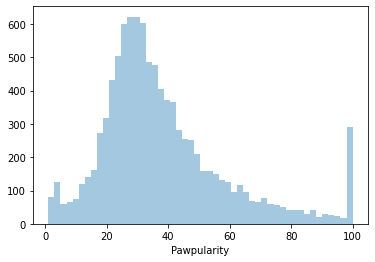

In [19]:
sns.distplot(train["Pawpularity"], kde=False)

# Preprocess

In [20]:
def train_preprocess(df):
    df["Pawpularity100"] = np.where(df["Pawpularity"] == 100, 1, 0)

    return df

In [21]:
if Config.train3:
    train = train_preprocess(df)
    train["Pawpularity100"].value_counts()

# EDA 2

# 👑 Load Artifacts

In [22]:
if Config.train2:
    api = wandb.Api()
    for artifact_id in config.models:
        name_version = artifact_id.replace(":", "-")
        if not os.path.exists(name_version):
            os.makedirs(name_version)

        try:
            artifact_path = f"{Config.wandb_entity}/{Config.wandb_project}/{artifact_id}"
            artifact = api.artifact(artifact_path)
            artifact.download(name_version)
        except Exception as e:
            print(f"Error: {artifact_path}, {e}")

In [23]:
if Config.validate:
    api = wandb.Api()

    for n, run_id in enumerate(config.runs):
        if not os.path.exists(run_id):
            os.makedirs(run_id)

        run_path = f"{Config.wandb_entity}/{Config.wandb_project}/{run_id}"
        run = api.run(run_path)

        try:
            run.file("oof_df.csv").download(run_id)
        except wandb.CommError:
            # Already downloaded.
            pass

        oof = pd.read_csv(f"{run_id}/oof_df.csv")[["Id", "preds"]]
        oof.columns = ["Id", f"preds{n}"]
        train = pd.merge(train, oof, on="Id")

    print(train.columns)

In [24]:
if Config.debug:
    train = train.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
    if len(sub) > Config.num_debug_data:
        test = test.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
        sub = sub.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)

# Utils

In [25]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)

# Make Fold

In [26]:
num_bins = int(np.floor(1 + np.log2(len(train))))
train.loc[:, "bins"] = pd.cut(train["Pawpularity"], bins=num_bins, labels=False)

In [27]:
Fold = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["bins"])):
    train.loc[val_index, "fold"] = int(n)
train["fold"] = train["fold"].astype(np.int8)
print(train.groupby(["fold", "bins"]).size())

fold  bins
0     0        33
      1        42
      2       111
      3       203
      4       188
             ... 
9     9        28
      10       20
      11       14
      12       11
      13       36
Length: 140, dtype: int64


# Dataset

In [28]:
if "crop image" in wandb_tags:
    TRAIN_IMAGE_PATH = DATA_DIR + "crop/"
    print("Use croped images.")

Use croped images.


In [29]:
class BaseDataset(Dataset):
    def __init__(self, df, transform=None, label=True):
        self.df = df
        self.file_names = df["Id"].values
        self.features = df.drop(["Id", "Pawpularity", "fold", "bins"], axis=1).values
        self.transform = transform

        self.use_label = label
        if self.use_label:
            self.path = TRAIN_IMAGE_PATH
            self.labels = df["Pawpularity"].values / 100.0
        else:
            self.path = TEST_IMAGE_PATH

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{self.path}/{file_name}.jpg"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        feature = torch.tensor(self.features[idx])
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        if self.use_label:
            label = torch.tensor(self.labels[idx])
            return image, feature, label
        return image, feature

In [30]:
if Config.debug:
    train_ds = BaseDataset(train)
    image, feature, label = train_ds[0]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

In [31]:
class DetectionDataset(Dataset):
    def __init__(self, df, force_input_size=None):
        self.df = df
        self.files = (f"{TRAIN_IMAGE_PATH}/" + df["Id"] + ".jpg").values

        input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]
        self.input_size = input_sizes[config.compound_coef] if force_input_size is None else force_input_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        ori_img, framed_img, framed_meta = preprocess(self.files[idx], max_size=self.input_size)

        x = torch.from_numpy(framed_img[0]).permute(2, 0, 1)

        return x, ori_img, framed_img, framed_meta

In [32]:
if Config.debug and Config.preprocess:
    train_ds = DetectionDataset(train)
    x, ori_img, framed_img, framed_meta = train_ds[0]
    plt.imshow(framed_img[0])
    plt.show()

# Transform

In [33]:
def get_transforms(*, data):
    if data == "train":
        if "basic aug" in wandb_tags:
            return A.Compose(
                [
                    # A.Resize(config.size, config.size),
                    A.RandomResizedCrop(config.size, config.size),
                    A.Transpose(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.ShiftScaleRotate(p=0.5),
                    A.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                    ),
                    ToTensorV2(),
                ]
            )

        if "heavy aug" in wandb_tags:
            return A.Compose(
                [
                    # A.Resize(config.size, config.size),
                    A.RandomResizedCrop(config.size, config.size),
                    A.Transpose(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.ShiftScaleRotate(p=0.5),
                    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                    # A.CoarseDropout(p=0.5),
                    # A.Cutout(p=0.5),
                    A.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                    ),
                    ToTensorV2(),
                ]
            )

    return A.Compose(
        [
            A.Resize(config.size, config.size),
            # A.CenterCrop(config.size, config.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ]
    )

In [34]:
if Config.debug:
    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    image, feature, label = train_ds[0]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

## CutMix

In [35]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(x, feats, y, alpha=1.0, use_cuda=True):
    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    mixed_x = x.clone()
    mixed_x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    mixed_feats = lam * feats + (1 - lam) * feats[index]
    y_a, y_b = y, y[index]

    return mixed_x, mixed_feats, y_a, y_b, lam

In [36]:
if Config.debug and config.model_name != "":
    train_ds = BaseDataset(train, transform=get_transforms(data="valid"))
    train_loader = DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        image, feature, label_a, label_b, lam = cutmix(image, feature, label, alpha=0.5, use_cuda=False)

        plt.imshow(image[0].permute(1, 2, 0))
        plt.title(f"label: {label_a[0]} and {label_b[0]}")
        plt.show()

        print(f"feature: {feature[0]}, lam: {lam}")
        break

## MixUp

In [37]:
# https://github.com/yuhao318/mwh/blob/main/utils.py
def mixup(x, feats, y, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_feats = lam * feats + (1 - lam) * feats[index]
    y_a, y_b = y, y[index]

    # return mixed_image, mixed_label, lam
    return mixed_x, mixed_feats, y_a, y_b, lam

In [38]:
if Config.debug and config.model_name != "":
    train_ds = BaseDataset(train, transform=get_transforms(data="valid"))
    train_loader = DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        image, feature, label_a, label_b, lam = mixup(image, feature, label, alpha=0.5, use_cuda=False)

        plt.imshow(image[0].permute(1, 2, 0))
        plt.title(f"label: {label_a[0]} and {label_b[0]}")
        plt.show()

        print(f"feature: {feature[0]}, lam: {lam}")
        break

# 🚗 Model

In [39]:
# https://github.com/pytorch/pytorch/issues/3867
# TODO: Padding same の nn.Conv2d


# https://github.com/tmp-iclr/convmixer
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x


def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=1000):
    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[
            nn.Sequential(
                Residual(
                    nn.Sequential(
                        nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"), nn.GELU(), nn.BatchNorm2d(dim)
                    )
                ),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim),
            )
            for i in range(depth)
        ],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )


_cfg = {
    "url": "",
    "num_classes": 1000,
    "input_size": (3, 224, 224),
    "pool_size": None,
    "crop_pct": 0.96,
    "interpolation": "bicubic",
    "mean": timm.data.IMAGENET_DEFAULT_MEAN,
    "std": timm.data.IMAGENET_DEFAULT_STD,
    "classifier": "head",
}


@timm.models.registry.register_model
def convmixer_1536_20(pretrained=False, **kwargs):
    model = ConvMixer(1536, 20, kernel_size=9, patch_size=7, n_classes=128)
    model.default_cfg = _cfg
    return model


@timm.models.registry.register_model
def convmixer_768_32(pretrained=False, **kwargs):
    model = ConvMixer(768, 32, kernel_size=7, patch_size=7, n_classes=128)
    model.default_cfg = _cfg
    return model

## Base model

In [40]:
class BaseModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if "resnext50_32x4d" in model_name:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, 128)

        elif "efficientnet" in model_name:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, 128)

        elif any(key in model_name for key in ["vit", "swin", "CSWin"]):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, 128)

        if "no feats" in wandb_tags:
            self.head2 = nn.Linear(128, config.n_class)
        else:
            self.dropout = nn.Dropout(0.1)
            self.head1 = nn.Linear(140, 64)
            self.head2 = nn.Linear(64, config.n_class)

    @amp.autocast(enabled=Config.amp)
    def forward(self, x, feats):
        x = self.model(x)
        if "no feats" in wandb_tags:
            x = self.head2(x)
        else:
            x = self.dropout(x)
            x = torch.cat([x, feats], dim=1)
            x = self.head1(x)
        return x

In [41]:
def train_mode(model):
    model.train()

    # Freeze layer normalization
    if any(key in config.model_name for key in ["vit", "swin", "CSWin"]):
        for m in model.modules():
            for child in m.children():
                if isinstance(child, nn.LayerNorm):
                    for param in child.parameters():
                        param.requires_grad = False

In [42]:
if False and Config.debug and config.model_name != "":
    model = BaseModel(config.model_name)
    print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        output = model(image, feature)
        print(output)
        break

In [43]:
if False and Config.debug and config.model_name != "":
    model = BaseModel(config.model_name)
    model.apply(train_mode)

    for n, (name, tensor) in enumerate(list(model.named_parameters())):
        print(f"{n:>4}: {tensor.requires_grad}, {name}")

## Backbone model

In [44]:
class BackboneModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if "resnext50_32x4d" in model_name:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, 128)

        elif "efficientnet" in model_name:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, 128)

        elif any(key in model_name for key in ["vit", "swin", "CSWin"]):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, 128)

        self.dropout = nn.Dropout(0.1)
        self.head1 = nn.Linear(140, 64)
        self.head2 = nn.Linear(64, config.n_class)

    @amp.autocast(enabled=Config.amp)
    def forward(self, x, feats):
        x = self.model(x)
        # x = self.dropout(x)
        x = torch.cat([x, feats], dim=1)
        # x = self.head1(x)
        # x = self.head2(x)
        return x

In [45]:
if False and Config.debug and config.model_name != "":
    model = BackboneModel(config.model_name)
    print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        output = model(image, feature)
        print(output)
        break

# Optimizer

In [46]:
# https://github.com/davda54/sam/blob/main/sam.py
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    # @torch.no_grad()
    @torch.inference_mode()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None:
                    continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad:
            self.zero_grad()

    # @torch.no_grad()
    @torch.inference_mode()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad:
            self.zero_grad()

    # @torch.no_grad()
    @torch.inference_mode()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][
            0
        ].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
            torch.stack(
                [
                    ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                    for group in self.param_groups
                    for p in group["params"]
                    if p.grad is not None
                ]
            ),
            p=2,
        )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

# Loss

In [47]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

# Scoring

In [48]:
def get_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [49]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["Pawpularity"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    if fold == config.n_fold:
        wandb.log({"Score": score})
    else:
        wandb.log({f"Score_fold{fold}": score})

# Helper functions

In [50]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

## Early stopping

In [51]:
# https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path="checkpoint.pt", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.best_preds = None

    def __call__(self, val_loss, score, model, preds):

        if self.best_score is None:
            self.best_score = score
            self.best_preds = preds
            self.save_checkpoint(val_loss, model)
        elif val_loss >= self.val_loss_min + self.delta:
            if self.patience <= 0:
                return
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_preds = preds
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Grad norm

In [52]:
def compute_grad_norm(parameters, norm_type=2.0):
    """Refer to torch.nn.utils.clip_grad_norm_"""
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    norm_type = float(norm_type)
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type
    total_norm = total_norm ** (1.0 / norm_type)
    return total_norm

## Preprocess

In [53]:
def preprocess_fn(data_loader, model, device):
    pass

## Training

In [54]:
def train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device):
    losses = AverageMeter()

    # switch to train mode
    if "freeze norm" in wandb_tags:
        model.apply(train_mode)
    else:
        model.train()
    start = time.time()
    optimizer.zero_grad()

    for step, (images, features, labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        if epoch < 2 or epoch >= config.epochs - 2:
            mix_decision = 1.0
        else:
            mix_decision = np.random.rand()

        if epoch >= config.epochs - 5:
            mix_decision *= 2

        if "mixup" in wandb_tags and mix_decision < 0.5:
            images, features, label_a, label_b, lam = mixup(images, features, labels, alpha=0.5)

        with amp.autocast(enabled=Config.amp):
            # y_preds = model(images, features)
            y_preds = model(images, features).squeeze(1)

            if "mixup" in wandb_tags and mix_decision < 0.5:
                loss = criterion(y_preds, label_a) * lam + criterion(y_preds, label_b) * (1.0 - lam)
            else:
                loss = criterion(y_preds, labels)

            losses.update(loss.item(), batch_size)
            loss = loss / config.gradient_accumulation_steps

            if "SAM" in config.optimizer:

                def closure():
                    # y_preds = model(images, features)
                    y_preds = model(images, features).squeeze(1)

                    if "mixup" in wandb_tags and mix_decision < 0.5:
                        loss = criterion(y_preds, label_a) * lam + criterion(y_preds, label_b) * (1.0 - lam)
                    else:
                        loss = criterion(y_preds, labels)

                    loss.backward()
                    return loss

        scaler.scale(loss).backward()

        if (step + 1) % config.gradient_accumulation_steps == 0:
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

            if "SAM" in config.optimizer:
                scaler.step(optimizer, closure)
            else:
                scaler.step(optimizer)

            scaler.update()

            optimizer.zero_grad()
            scheduler.step()
        else:
            grad_norm = compute_grad_norm(model.parameters())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.avg:.4f} "
                f"Grad: {grad_norm:.4f} "
                f"LR: {scheduler.get_lr()[0]:.2e}  "
            )

    return losses.avg

## Validation

In [55]:
def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = time.time()

    for step, (images, features, labels) in enumerate(valid_loader):
        images = images.to(device)
        features = features.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # with torch.no_grad():
        with torch.inference_mode():
            # y_preds = model(images, features)
            y_preds = model(images, features).squeeze(1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )

    predictions = np.concatenate(preds)
    return losses.avg, predictions

## Training2 (Inference by backbone)

In [56]:
def train2_inference_fn(data_loader, model, device):
    # switch to evaluation mode
    model.eval()
    preds = []
    start = time.time()

    for step, (images, features, labels) in enumerate(data_loader):
        images = images.to(device)
        features = features.to(device)

        # with torch.no_grad():
        with torch.inference_mode():
            y_preds = model(images, features)
            # y_preds = model(images, features).squeeze(1)

        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(data_loader) - 1):
            print(
                f"EVAL: [{step}/{len(data_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(data_loader)):s} "
            )

    predictions = np.concatenate(preds)
    return predictions

# Postprocess

# 🏃‍♂️ Preprocess Loop

In [57]:
def save_image(preds, imgs, files, imshow=False, imwrite=True):
    for i in range(len(imgs)):
        # if len(preds[i]['rois']) == 0:
        #     continue

        imgs[i] = imgs[i].copy()

        for j in range(len(preds[i]["rois"])):
            # cat or dog
            if preds[i]["class_ids"][j] not in (16, 17):
                continue
            
            x1, y1, x2, y2 = preds[i]["rois"][j].astype(np.int)
            # obj = obj_list[preds[i]["class_ids"][j]]
            # score = float(preds[i]["scores"][j])
            # plot_one_box(
            #     imgs[i], [x1, y1, x2, y2], label=obj, score=score, color=color_list[get_index_label(obj, obj_list)]
            # )

            # Crop image
            imgs[i] = imgs[i][y1:y2, x1:x2, :]

            # Apply only highest preds
            break

        if imshow:
            cv2.imshow("img", imgs[i])
            cv2.waitKey(0)

        if imwrite:
            cv2.imwrite(f"{DATA_DIR}/crop/{os.path.basename(files[i])}", imgs[i])

In [58]:
def preprocess_loop(df):
    crop_output_dir = f"{DATA_DIR}/crop/"
    !rm -rf {crop_output_dir}
    os.makedirs(crop_output_dir, exist_ok=True)
    
    # replace this part with your project's anchor config
    anchor_ratios = [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]
    anchor_scales = [2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]

    threshold = 0.2
    iou_threshold = 0.2

    color_list = standard_to_bgr(STANDARD_COLORS)
    # tf bilinear interpolation is different from any other's, just make do
    force_input_size = None  # set None to use default size
    input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]
    input_size = input_sizes[config.compound_coef] if force_input_size is None else force_input_size

    model = EfficientDetBackbone(
        compound_coef=config.compound_coef, num_classes=90, ratios=anchor_ratios, scales=anchor_scales
    )
    model.load_state_dict(
        torch.load(f"../input/pretrained-weights/efficientdet-d{config.compound_coef}.pth", map_location="cpu")
    )

    if Config.multi_gpu:
        model = nn.DataParallel(model)
    model.to(device)

    model.requires_grad_(False)
    model.eval()

    files = (f"{TRAIN_IMAGE_PATH}/" + df["Id"] + ".jpg").values

    for file_ in tqdm(files, total=len(files)):
        ori_imgs, framed_imgs, framed_metas = preprocess(file_, max_size=input_size)
        x = torch.stack([torch.from_numpy(fi).to(device) for fi in framed_imgs], 0).permute(0, 3, 1, 2)

        # with torch.no_grad():
        with torch.inference_mode():
            _, regression, classification, anchors = model(x)

            regressBoxes = BBoxTransform()
            clipBoxes = ClipBoxes()

            out = postprocess(x, anchors, regression, classification, regressBoxes, clipBoxes, threshold, iou_threshold)

        out = invert_affine(framed_metas, out)
        save_image(out, ori_imgs, [file_])

# 🏃‍♂️ Train loop

In [59]:
def train_loop(df, fold):
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_ = BaseDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = BaseDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_ = DataLoader(
        train_dataset_,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Optimizer
    # ====================================================
    def get_optimizer(model):
        if config.optimizer == "Adam":
            optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == "AdamW":
            optimizer = AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == "SAM":
            base_optimizer = SGD
            optimizer = SAM(
                model.parameters(),
                base_optimizer,
                lr=config.lr,
                momentum=config.momentum,
                weight_decay=config.weight_decay,
            )
        elif config.optimizer == "ASAM":
            base_optimizer = SGD
            optimizer = SAM(
                model.parameters(),
                base_optimizer,
                lr=config.lr,
                momentum=config.momentum,
                weight_decay=config.weight_decay,
                rho=2.0,
                adaptive=True,
            )
        return optimizer

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer, train_dataset):
        num_data = len(train_dataset)
        num_steps = num_data // (config.batch_size * config.gradient_accumulation_steps) * config.epochs

        if config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(
                optimizer, T_0=num_steps, T_mult=1, eta_min=config.min_lr, last_epoch=-1
            )
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=num_steps, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=num_steps,
                max_lr=config.lr,
                min_lr=config.min_lr,
                warmup_steps=(num_steps // 10),
            )
        return scheduler

    # ====================================================
    # Model
    # ====================================================
    model = BaseModel(config.model_name)
    if Config.multi_gpu:
        model = nn.DataParallel(model)
    model.to(device)

    optimizer = get_optimizer(model)
    scaler = amp.GradScaler(enabled=Config.amp)
    scheduler = get_scheduler(optimizer, train_dataset)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        elif config.criterion == "MSELoss":
            criterion = nn.MSELoss()
        return criterion

    criterion = get_criterion()

    # ====================================================
    # Early stopping
    # ====================================================
    es = EarlyStopping(
        patience=config.es_patience,
        verbose=True,
        path=MODEL_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth",
    )

    # ====================================================
    # Loop
    # ====================================================
    best_score = -1
    best_loss = np.inf
    best_preds = None

    for epoch in range(config.epochs):
        start_time = time.time()

        # train
        if epoch < 2 or epoch >= config.epochs - 2:
            avg_loss = train_fn(train_loader_, model, criterion, optimizer, scheduler, scaler, epoch, device)
        else:
            avg_loss = train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["Pawpularity"].values

        if config.criterion == "BCEWithLogitsLoss":
            preds = 1 / (1 + np.exp(-preds))

        preds *= 100.0

        # scoring
        # score = get_score(valid_labels, preds.argmax(1))
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log(
            {
                "epoch": epoch + 1,
                f"loss/train_fold{fold}": avg_loss,
                f"loss/valid_fold{fold}": avg_val_loss,
                f"score/fold{fold}": score,
            }
        )

        es(avg_val_loss, score, model, preds)

        if es.early_stop:
            print("Early stopping")
            break

    # valid_folds[[str(c) for c in range(config.n_class)]] = es.best_preds
    # valid_folds["preds"] = es.best_preds.argmax(1)
    valid_folds["preds"] = es.best_preds

    return valid_folds, es.best_score, es.val_loss_min

# 🏃‍♂️ Train2 loop

In [60]:
def train2_loop(df, artifact_id, fold):
    LOGGER.info(f"========== ID: {artifact_id} fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = BaseDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    valid_labels = valid_folds["Pawpularity"].values

    # ====================================================
    # Model
    # ====================================================
    model_name = artifact_id.split(":")[0]
    model = BackboneModel(model_name)
    if Config.multi_gpu:
        model = nn.DataParallel(model)
    model.to(device)

    path = f"{artifact_id.replace(':', '-')}/{model_name}_fold{fold}_best.pth"
    model.load_state_dict(torch.load(path))

    # ====================================================
    # Inference by backbone
    # ====================================================

    train_preds = train2_inference_fn(train_loader, model, device)
    valid_preds = train2_inference_fn(valid_loader, model, device)

    scaler = StandardScaler()
    # scaler.fit(np.vstack([train_preds, valid_preds]))

    train_norm = scaler.fit_transform(train_preds)
    valid_norm = scaler.transform(valid_preds)

    scaler_path = MODEL_DIR + f"{model_name}-StandardScaler_fold{fold}_best.pkl"
    pickle.dump(scaler, open(scaler_path, "wb"))

    # ====================================================
    # Tuning SVR parameters
    # ====================================================
    # https://github.com/hkaneko1985/fastoptsvrhyperparams/blob/master/fastoptsvrhyperparams.ipynb
    start_time = time.time()

    svr_epss = 2 ** np.arange(-10, 1, dtype=float)  # Candidates of epsilon
    svr_cs = 2 ** np.arange(-5, 11, dtype=float)  # Candidates of C
    svr_gammas = 2 ** np.arange(-20, 11, dtype=float)  # Candidates of gamma

    # Optimize epsilon with cross-validation
    model_tune_eps = GridSearchCV(SVR(kernel="rbf", C=3), {"epsilon": svr_epss}, verbose=1)
    model_tune_eps.fit(train_norm, train_dataset.labels)
    optimal_eps = model_tune_eps.best_params_["epsilon"]
    elapsed = time.time() - start_time
    print(f"Optimized eps: {elapsed:.0f}s")

    # Optimize C with cross-validation
    model_tune_c = GridSearchCV(SVR(kernel="rbf", epsilon=optimal_eps), {"C": svr_cs}, verbose=1)
    model_tune_c.fit(train_norm, train_dataset.labels)
    optimal_c = model_tune_c.best_params_["C"]
    elapsed = time.time() - start_time
    print(f"Optimized c: {elapsed:.0f}s")

    # Optimize gamma with cross-validation (optional)
    model_tune_gamma = GridSearchCV(
        SVR(kernel="rbf", epsilon=optimal_eps, C=optimal_c), {"gamma": svr_gammas}, verbose=1
    )
    model_tune_gamma.fit(train_norm, train_dataset.labels)
    optimal_gamma = model_tune_gamma.best_params_["gamma"]
    elapsed = time.time() - start_time
    print(f"Optimized gamma: {elapsed:.0f}s")

    best_params = {
        "C": optimal_c,
        "epsilon": optimal_eps,
        "gamma": optimal_gamma,
    }
    print(f"{best_params}")

    param_path = MODEL_DIR + f"{model_name}-SVR-params_fold{fold}_best.json"
    with open(param_path, "w") as f:
        json.dump(best_params, f, indent=4)

    # ====================================================
    # Training SVR
    # ====================================================
    start_time = time.time()

    model_svr = SVR(C=optimal_c, epsilon=optimal_eps, gamma=optimal_gamma)
    model_svr.fit(train_norm, train_dataset.labels)

    preds = model_svr.predict(valid_norm)
    preds *= 100.0

    # scoring
    # score = get_score(valid_labels, preds.argmax(1))
    score = get_score(valid_labels, preds)

    elapsed = time.time() - start_time
    LOGGER.info(f"Score: {score}  time: {elapsed:.0f}s")

    svr_path = MODEL_DIR + f"{model_name}-SVR_fold{fold}_best.pkl"
    pickle.dump(model_svr, open(svr_path, "wb"))

    # valid_folds[[str(c) for c in range(config.n_class)]] = es.best_preds
    # valid_folds["preds"] = es.best_preds.argmax(1)
    # valid_folds["preds"] = es.best_preds
    valid_folds["preds"] = preds

    return valid_folds, score

# Main function

In [61]:
def main():
    # ====================================================
    # Preprocess
    # ====================================================
    if Config.preprocess:
        preprocess_loop(train)

    # ====================================================
    # Training
    # ====================================================
    if Config.train:
        oof_df = pd.DataFrame()
        oof_result = []
        for fold in range(config.n_fold):
            seed_torch(seed + fold)

            _oof_df, score, loss = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            oof_result.append([fold, score, loss])

            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)
            
            break

        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)

        loss = statistics.mean([d[2] for d in oof_result])
        wandb.log({"loss": loss})

        table = wandb.Table(data=oof_result, columns=["fold", "score", "loss"])
        run.log({"Fold Result": table})

        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")

        artifact = wandb.Artifact(config.model_name, type="model")
        artifact.add_dir(MODEL_DIR)
        run.log_artifact(artifact)

    # ====================================================
    # Validation
    # ====================================================
    if Config.validate:
        cols = [f"preds{n}" for n in range(len(config.runs))]
        train["preds"] = train[cols].values.mean(axis=1)

        LOGGER.info(f"========== CV ==========")
        get_result(train)

        # save result
        train.to_csv(OUTPUT_DIR + "validation_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "validation_df.csv")

    # ====================================================
    # Training SVR
    # ====================================================
    if Config.train2:
        oof_df = pd.DataFrame()
        oof_result = []
        for n, artifact_id in enumerate(config.models):

            for fold in range(config.n_fold):
                seed_torch(seed + fold)
                _oof_df, score = train2_loop(train, artifact_id, fold)
                oof_df = pd.concat([oof_df, _oof_df])

                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df, fold)

            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(oof_df)

            break

        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")

        artifact = wandb.Artifact(f"{artifact_id.split(':')[0]}-SVR", type="model")
        artifact.add_dir(MODEL_DIR)
        run.log_artifact(artifact)

# 🚀 Run

In [62]:
main()

========== fold: 0 training ==========


Epoch: [1][0/139] Elapsed 0m 26s (remain 62m 1s) Loss: 0.6849 Grad: 0.8255 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 24s (remain 0m 31s) Loss: 0.6531 Grad: 0.4176 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 46s (remain 0m 0s) Loss: 0.6512 Grad: 0.4929 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 25s) Loss: 0.6627 


Epoch 1 - avg_train_loss: 0.6512  avg_val_loss: 0.6436  time: 114s
Epoch 1 - Score: 17.896329174554683


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6436 
Validation loss decreased (inf --> 0.643622).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 4m 41s) Loss: 0.6364 Grad: 0.7431 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6380 Grad: 0.9707 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6377 Grad: 0.6070 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 24s) Loss: 0.6618 


Epoch 2 - avg_train_loss: 0.6377  avg_val_loss: 0.6421  time: 90s
Epoch 2 - Score: 17.672290955413143


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6421 
Validation loss decreased (0.643622 --> 0.642150).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 5m 12s) Loss: 0.6702 Grad: 0.7872 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6471 Grad: 0.9863 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6467 Grad: 0.4523 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 25s) Loss: 0.6634 


Epoch 3 - avg_train_loss: 0.6467  avg_val_loss: 0.6428  time: 91s
Epoch 3 - Score: 17.752777714185264


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6428 
Epoch: [4][0/139] Elapsed 0m 2s (remain 4m 51s) Loss: 0.6416 Grad: 0.4447 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6459 Grad: 0.6649 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6454 Grad: 0.6251 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 25s) Loss: 0.6660 


Epoch 4 - avg_train_loss: 0.6454  avg_val_loss: 0.6431  time: 91s
Epoch 4 - Score: 17.790269565946748


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6431 
Epoch: [5][0/139] Elapsed 0m 2s (remain 4m 49s) Loss: 0.6628 Grad: 0.8749 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6424 Grad: 0.8744 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6433 Grad: 0.5217 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6620 


Epoch 5 - avg_train_loss: 0.6433  avg_val_loss: 0.6417  time: 90s
Epoch 5 - Score: 17.610964920511847


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6417 
Validation loss decreased (0.642150 --> 0.641700).  Saving model ...
Epoch: [6][0/139] Elapsed 0m 2s (remain 4m 43s) Loss: 0.6695 Grad: 1.0425 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6409 Grad: 0.8415 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6418 Grad: 0.7717 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 25s) Loss: 0.6644 


Epoch 6 - avg_train_loss: 0.6418  avg_val_loss: 0.6427  time: 90s
Epoch 6 - Score: 17.73127333446184


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6427 
Epoch: [7][0/139] Elapsed 0m 2s (remain 4m 45s) Loss: 0.6408 Grad: 0.6232 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 1s (remain 0m 22s) Loss: 0.6403 Grad: 0.9893 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6413 Grad: 0.5663 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6638 


Epoch 7 - avg_train_loss: 0.6413  avg_val_loss: 0.6423  time: 91s
Epoch 7 - Score: 17.673156098223316


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6423 
Epoch: [8][0/139] Elapsed 0m 2s (remain 4m 55s) Loss: 0.6610 Grad: 1.0911 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6393 Grad: 0.9174 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 20s (remain 0m 0s) Loss: 0.6400 Grad: 0.6082 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6644 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6430 


Epoch 8 - avg_train_loss: 0.6400  avg_val_loss: 0.6430  time: 89s
Epoch 8 - Score: 17.760966662412525


Epoch: [9][0/139] Elapsed 0m 2s (remain 5m 32s) Loss: 0.6285 Grad: 0.3342 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6256 Grad: 1.0852 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6261 Grad: 0.5554 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 24s) Loss: 0.6654 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6433 


Epoch 9 - avg_train_loss: 0.6261  avg_val_loss: 0.6433  time: 90s
Epoch 9 - Score: 17.777573913619637


Epoch: [10][0/139] Elapsed 0m 2s (remain 4m 42s) Loss: 0.6265 Grad: 0.5697 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6243 Grad: 0.6879 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6241 Grad: 0.7300 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6664 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6441 


Epoch 10 - avg_train_loss: 0.6241  avg_val_loss: 0.6441  time: 90s
Epoch 10 - Score: 17.862830366967856
========== fold: 0 result ==========
Score: 17.61096
========== fold: 1 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 5m 5s) Loss: 0.7025 Grad: 1.0569 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6552 Grad: 0.5812 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6527 Grad: 0.4437 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 28s) Loss: 0.6306 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6413 


Epoch 1 - avg_train_loss: 0.6527  avg_val_loss: 0.6413  time: 91s
Epoch 1 - Score: 17.823165179049123


Validation loss decreased (inf --> 0.641269).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 5m 9s) Loss: 0.6214 Grad: 1.0252 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6383 Grad: 0.6348 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6383 Grad: 0.5484 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6278 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6396 


Epoch 2 - avg_train_loss: 0.6383  avg_val_loss: 0.6396  time: 92s
Epoch 2 - Score: 17.601810955892084


Validation loss decreased (0.641269 --> 0.639582).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 5m 0s) Loss: 0.6665 Grad: 0.7024 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6471 Grad: 0.5296 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6475 Grad: 0.5088 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6253 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6394 


Epoch 3 - avg_train_loss: 0.6475  avg_val_loss: 0.6394  time: 91s
Epoch 3 - Score: 17.57404560359141


Validation loss decreased (0.639582 --> 0.639399).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 2s (remain 5m 24s) Loss: 0.6275 Grad: 0.7542 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6449 Grad: 0.6387 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6448 Grad: 0.7927 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6249 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6393 


Epoch 4 - avg_train_loss: 0.6448  avg_val_loss: 0.6393  time: 89s
Epoch 4 - Score: 17.55218962037771


Validation loss decreased (0.639399 --> 0.639268).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 2s (remain 4m 52s) Loss: 0.6614 Grad: 0.5764 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6437 Grad: 0.6811 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6428 Grad: 0.7539 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6258 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6404 


Epoch 5 - avg_train_loss: 0.6428  avg_val_loss: 0.6404  time: 90s
Epoch 5 - Score: 17.66840470417774


Epoch: [6][0/139] Elapsed 0m 2s (remain 5m 12s) Loss: 0.6407 Grad: 0.5591 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6408 Grad: 0.8489 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 20s (remain 0m 0s) Loss: 0.6420 Grad: 0.4125 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 28s) Loss: 0.6243 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6401 


Epoch 6 - avg_train_loss: 0.6420  avg_val_loss: 0.6401  time: 89s
Epoch 6 - Score: 17.649944883447173


Epoch: [7][0/139] Elapsed 0m 2s (remain 4m 54s) Loss: 0.6540 Grad: 0.9978 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6404 Grad: 0.5927 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6408 Grad: 0.4209 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6250 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6392 


Epoch 7 - avg_train_loss: 0.6408  avg_val_loss: 0.6392  time: 91s
Epoch 7 - Score: 17.52926945330713


Validation loss decreased (0.639268 --> 0.639224).  Saving model ...
Epoch: [8][0/139] Elapsed 0m 2s (remain 4m 51s) Loss: 0.6444 Grad: 0.6016 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6405 Grad: 0.5989 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6396 Grad: 0.8270 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 28s) Loss: 0.6259 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6394 


Epoch 8 - avg_train_loss: 0.6396  avg_val_loss: 0.6394  time: 92s
Epoch 8 - Score: 17.55638490274438


Epoch: [9][0/139] Elapsed 0m 2s (remain 5m 5s) Loss: 0.6493 Grad: 0.5860 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6286 Grad: 0.4742 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6275 Grad: 0.5268 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6256 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6395 


Epoch 9 - avg_train_loss: 0.6275  avg_val_loss: 0.6395  time: 89s
Epoch 9 - Score: 17.557959395162207


Epoch: [10][0/139] Elapsed 0m 2s (remain 5m 23s) Loss: 0.6288 Grad: 0.7649 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6262 Grad: 0.4854 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6255 Grad: 0.8357 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 28s) Loss: 0.6256 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6398 


Epoch 10 - avg_train_loss: 0.6255  avg_val_loss: 0.6398  time: 91s
Epoch 10 - Score: 17.599367318919313
========== fold: 1 result ==========
Score: 17.52927
========== fold: 2 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 4m 54s) Loss: 0.6959 Grad: 1.0033 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6541 Grad: 0.3596 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6516 Grad: 0.4401 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6339 


Epoch 1 - avg_train_loss: 0.6516  avg_val_loss: 0.6444  time: 91s
Epoch 1 - Score: 18.2799494066645


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6444 
Validation loss decreased (inf --> 0.644409).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 4m 47s) Loss: 0.6273 Grad: 0.5473 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6381 Grad: 0.4614 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6375 Grad: 0.7807 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6363 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6427 


Epoch 2 - avg_train_loss: 0.6375  avg_val_loss: 0.6427  time: 91s
Epoch 2 - Score: 18.07281378544427


Validation loss decreased (0.644409 --> 0.642661).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 4m 43s) Loss: 0.6373 Grad: 0.6304 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6470 Grad: 1.0984 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6465 Grad: 0.6106 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6356 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6457 


Epoch 3 - avg_train_loss: 0.6465  avg_val_loss: 0.6457  time: 91s
Epoch 3 - Score: 18.429085041100546


Epoch: [4][0/139] Elapsed 0m 2s (remain 4m 54s) Loss: 0.6485 Grad: 0.7701 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6450 Grad: 0.4845 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6447 Grad: 0.3908 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 25s) Loss: 0.6347 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6435 


Epoch 4 - avg_train_loss: 0.6447  avg_val_loss: 0.6435  time: 91s
Epoch 4 - Score: 18.17200765569571


Epoch: [5][0/139] Elapsed 0m 2s (remain 4m 56s) Loss: 0.6399 Grad: 0.7363 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 1s (remain 0m 22s) Loss: 0.6436 Grad: 0.6217 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6428 Grad: 1.1141 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6367 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6433 


Epoch 5 - avg_train_loss: 0.6428  avg_val_loss: 0.6433  time: 91s
Epoch 5 - Score: 18.149149692876836


Epoch: [6][0/139] Elapsed 0m 2s (remain 5m 5s) Loss: 0.6430 Grad: 0.5826 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6409 Grad: 0.5720 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6410 Grad: 0.7308 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6372 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6437 


Epoch 6 - avg_train_loss: 0.6410  avg_val_loss: 0.6437  time: 91s
Epoch 6 - Score: 18.193557680691907


Epoch: [7][0/139] Elapsed 0m 2s (remain 4m 56s) Loss: 0.6302 Grad: 0.4286 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6416 Grad: 0.6494 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6402 Grad: 0.4971 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6384 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6440 


Epoch 7 - avg_train_loss: 0.6402  avg_val_loss: 0.6440  time: 90s
Epoch 7 - Score: 18.2258388655884


Epoch: [8][0/139] Elapsed 0m 2s (remain 5m 6s) Loss: 0.6506 Grad: 0.5585 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6399 Grad: 0.7967 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 20s (remain 0m 0s) Loss: 0.6400 Grad: 0.3887 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6385 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6440 


Epoch 8 - avg_train_loss: 0.6400  avg_val_loss: 0.6440  time: 89s
Epoch 8 - Score: 18.232203966264336


Epoch: [9][0/139] Elapsed 0m 2s (remain 5m 11s) Loss: 0.6304 Grad: 0.3918 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6273 Grad: 0.4999 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6267 Grad: 0.4196 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6391 


Epoch 9 - avg_train_loss: 0.6267  avg_val_loss: 0.6439  time: 90s
Epoch 9 - Score: 18.22008329565255


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6439 
Epoch: [10][0/139] Elapsed 0m 2s (remain 4m 43s) Loss: 0.6149 Grad: 0.5054 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6247 Grad: 0.8131 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6251 Grad: 0.6805 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6400 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6442 


Epoch 10 - avg_train_loss: 0.6251  avg_val_loss: 0.6442  time: 91s
Epoch 10 - Score: 18.265993967409273
========== fold: 2 result ==========
Score: 18.07281
========== fold: 3 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 5m 0s) Loss: 0.6993 Grad: 1.0266 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6527 Grad: 0.4360 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 20s (remain 0m 0s) Loss: 0.6510 Grad: 0.4091 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6445 


Epoch 1 - avg_train_loss: 0.6510  avg_val_loss: 0.6398  time: 89s
Epoch 1 - Score: 17.490573020415667


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6398 
Validation loss decreased (inf --> 0.639798).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 4m 46s) Loss: 0.6188 Grad: 0.3634 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6386 Grad: 0.4841 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6383 Grad: 0.2738 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6456 


Epoch 2 - avg_train_loss: 0.6383  avg_val_loss: 0.6372  time: 91s
Epoch 2 - Score: 17.132468567065438


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6372 
Validation loss decreased (0.639798 --> 0.637171).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 5m 17s) Loss: 0.6371 Grad: 0.5849 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6489 Grad: 0.9324 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6482 Grad: 0.4507 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6435 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6374 


Epoch 3 - avg_train_loss: 0.6482  avg_val_loss: 0.6374  time: 91s
Epoch 3 - Score: 17.1638755872736


Epoch: [4][0/139] Elapsed 0m 2s (remain 4m 39s) Loss: 0.6492 Grad: 0.6122 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6444 Grad: 1.3302 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6442 Grad: 0.7525 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6440 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6378 


Epoch 4 - avg_train_loss: 0.6442  avg_val_loss: 0.6378  time: 91s
Epoch 4 - Score: 17.213272219093508


Epoch: [5][0/139] Elapsed 0m 2s (remain 4m 47s) Loss: 0.6445 Grad: 0.6269 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6425 Grad: 0.9171 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6425 Grad: 2.8714 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6421 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6367 


Epoch 5 - avg_train_loss: 0.6425  avg_val_loss: 0.6367  time: 89s
Epoch 5 - Score: 17.067984946321857


Validation loss decreased (0.637171 --> 0.636722).  Saving model ...
Epoch: [6][0/139] Elapsed 0m 2s (remain 4m 46s) Loss: 0.6512 Grad: 0.4501 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6412 Grad: 1.8548 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6412 Grad: 0.4281 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6441 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6366 


Epoch 6 - avg_train_loss: 0.6412  avg_val_loss: 0.6366  time: 90s
Epoch 6 - Score: 17.06590147115428


Validation loss decreased (0.636722 --> 0.636588).  Saving model ...
Epoch: [7][0/139] Elapsed 0m 2s (remain 5m 6s) Loss: 0.6356 Grad: 0.8859 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6414 Grad: 0.4786 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6418 Grad: 0.5806 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 25s) Loss: 0.6437 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6361 


Epoch 7 - avg_train_loss: 0.6418  avg_val_loss: 0.6361  time: 91s
Epoch 7 - Score: 16.992232794443616


Validation loss decreased (0.636588 --> 0.636094).  Saving model ...
Epoch: [8][0/139] Elapsed 0m 2s (remain 4m 45s) Loss: 0.6455 Grad: 0.4965 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6406 Grad: 0.6037 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6400 Grad: 0.6253 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6438 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6370 


Epoch 8 - avg_train_loss: 0.6400  avg_val_loss: 0.6370  time: 91s
Epoch 8 - Score: 17.100784577641498


Epoch: [9][0/139] Elapsed 0m 2s (remain 4m 46s) Loss: 0.6512 Grad: 0.8070 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6272 Grad: 0.5570 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6275 Grad: 0.4167 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6432 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6357 


Epoch 9 - avg_train_loss: 0.6275  avg_val_loss: 0.6357  time: 91s
Epoch 9 - Score: 16.934143229899053


Validation loss decreased (0.636094 --> 0.635672).  Saving model ...
Epoch: [10][0/139] Elapsed 0m 2s (remain 4m 43s) Loss: 0.6167 Grad: 0.4185 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6257 Grad: 0.4046 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6256 Grad: 0.5579 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 28s) Loss: 0.6435 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6356 


Epoch 10 - avg_train_loss: 0.6256  avg_val_loss: 0.6356  time: 91s
Epoch 10 - Score: 16.930409817162857


Validation loss decreased (0.635672 --> 0.635644).  Saving model ...


========== fold: 3 result ==========
Score: 16.93041
========== fold: 4 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 5m 3s) Loss: 0.7188 Grad: 1.0767 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 0m 58s (remain 0m 22s) Loss: 0.6573 Grad: 0.4748 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 20s (remain 0m 0s) Loss: 0.6529 Grad: 0.4895 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 28s) Loss: 0.6439 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6457 


Epoch 1 - avg_train_loss: 0.6529  avg_val_loss: 0.6457  time: 88s
Epoch 1 - Score: 18.43119658439564


Validation loss decreased (inf --> 0.645714).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 4m 53s) Loss: 0.6385 Grad: 0.3860 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6389 Grad: 0.5001 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 20s (remain 0m 0s) Loss: 0.6383 Grad: 0.4941 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6453 


Epoch 2 - avg_train_loss: 0.6383  avg_val_loss: 0.6435  time: 89s
Epoch 2 - Score: 18.146356130903403


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6435 
Validation loss decreased (0.645714 --> 0.643520).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 4m 45s) Loss: 0.6417 Grad: 0.5591 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6479 Grad: 0.6297 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6466 Grad: 1.3674 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6401 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6443 


Epoch 3 - avg_train_loss: 0.6466  avg_val_loss: 0.6443  time: 91s
Epoch 3 - Score: 18.245773575872317


Epoch: [4][0/139] Elapsed 0m 2s (remain 4m 47s) Loss: 0.6395 Grad: 1.8756 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6452 Grad: 0.6072 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6454 Grad: 0.4736 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6421 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6435 


Epoch 4 - avg_train_loss: 0.6454  avg_val_loss: 0.6435  time: 91s
Epoch 4 - Score: 18.155757426883493


Epoch: [5][0/139] Elapsed 0m 2s (remain 4m 38s) Loss: 0.6430 Grad: 0.4259 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6416 Grad: 0.8406 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6428 Grad: 2.2822 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 28s) Loss: 0.6432 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6440 


Epoch 5 - avg_train_loss: 0.6428  avg_val_loss: 0.6440  time: 91s
Epoch 5 - Score: 18.222411103019066


Epoch: [6][0/139] Elapsed 0m 2s (remain 4m 52s) Loss: 0.6494 Grad: 0.6109 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6435 Grad: 0.5739 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6419 Grad: 0.8415 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6420 


Epoch 6 - avg_train_loss: 0.6419  avg_val_loss: 0.6445  time: 91s
Epoch 6 - Score: 18.26648780277215


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6445 
Epoch: [7][0/139] Elapsed 0m 2s (remain 5m 23s) Loss: 0.6450 Grad: 0.6078 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6416 Grad: 0.5835 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6412 Grad: 0.6274 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6428 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6442 


Epoch 7 - avg_train_loss: 0.6412  avg_val_loss: 0.6442  time: 90s
Epoch 7 - Score: 18.228157396319332


Epoch: [8][0/139] Elapsed 0m 2s (remain 4m 40s) Loss: 0.6508 Grad: 0.6053 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6400 Grad: 0.4957 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6399 Grad: 0.5693 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6415 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6442 


Epoch 8 - avg_train_loss: 0.6399  avg_val_loss: 0.6442  time: 90s
Epoch 8 - Score: 18.22825633433458


Epoch: [9][0/139] Elapsed 0m 2s (remain 4m 57s) Loss: 0.6232 Grad: 0.3982 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6282 Grad: 0.5782 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6272 Grad: 0.7453 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6434 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6439 


Epoch 9 - avg_train_loss: 0.6272  avg_val_loss: 0.6439  time: 89s
Epoch 9 - Score: 18.1928954896666


Epoch: [10][0/139] Elapsed 0m 2s (remain 5m 10s) Loss: 0.6355 Grad: 0.4494 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6266 Grad: 0.4388 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6257 Grad: 0.4722 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6436 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6440 


Epoch 10 - avg_train_loss: 0.6257  avg_val_loss: 0.6440  time: 91s
Epoch 10 - Score: 18.204336250264795
========== fold: 4 result ==========
Score: 18.14636
========== fold: 5 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 5m 11s) Loss: 0.7378 Grad: 1.4158 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6562 Grad: 0.8506 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6537 Grad: 0.4981 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6567 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6428 


Epoch 1 - avg_train_loss: 0.6537  avg_val_loss: 0.6428  time: 89s
Epoch 1 - Score: 17.78751042936503


Validation loss decreased (inf --> 0.642816).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 5m 0s) Loss: 0.6347 Grad: 0.4473 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6385 Grad: 2.5680 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6385 Grad: 0.6376 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6564 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6410 


Epoch 2 - avg_train_loss: 0.6385  avg_val_loss: 0.6410  time: 91s
Epoch 2 - Score: 17.533753329899273


Validation loss decreased (0.642816 --> 0.641034).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 5m 25s) Loss: 0.6524 Grad: 0.7336 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6492 Grad: 0.6027 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6479 Grad: 1.0668 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6556 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6395 


Epoch 3 - avg_train_loss: 0.6479  avg_val_loss: 0.6395  time: 91s
Epoch 3 - Score: 17.340148820799985


Validation loss decreased (0.641034 --> 0.639487).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 2s (remain 4m 42s) Loss: 0.6631 Grad: 0.6937 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6450 Grad: 0.6966 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6446 Grad: 0.4599 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6548 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6393 


Epoch 4 - avg_train_loss: 0.6446  avg_val_loss: 0.6393  time: 90s
Epoch 4 - Score: 17.302753574271666


Validation loss decreased (0.639487 --> 0.639316).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 2s (remain 5m 5s) Loss: 0.6689 Grad: 0.5541 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6439 Grad: 0.7996 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6433 Grad: 0.7228 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6544 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6393 


Epoch 5 - avg_train_loss: 0.6433  avg_val_loss: 0.6393  time: 91s
Epoch 5 - Score: 17.30443845411637


Validation loss decreased (0.639316 --> 0.639285).  Saving model ...
Epoch: [6][0/139] Elapsed 0m 2s (remain 5m 15s) Loss: 0.6366 Grad: 0.6017 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6424 Grad: 1.2142 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6418 Grad: 1.2570 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6565 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6398 


Epoch 6 - avg_train_loss: 0.6418  avg_val_loss: 0.6398  time: 90s
Epoch 6 - Score: 17.36649478688069


Epoch: [7][0/139] Elapsed 0m 2s (remain 4m 44s) Loss: 0.6504 Grad: 0.8304 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6422 Grad: 0.6778 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6419 Grad: 0.9323 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6566 


Epoch 7 - avg_train_loss: 0.6419  avg_val_loss: 0.6399  time: 91s
Epoch 7 - Score: 17.36043667361239


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6399 
Epoch: [8][0/139] Elapsed 0m 2s (remain 4m 44s) Loss: 0.6254 Grad: 1.2009 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6407 Grad: 0.7448 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6397 Grad: 0.6550 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6558 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6396 


Epoch 8 - avg_train_loss: 0.6397  avg_val_loss: 0.6396  time: 91s
Epoch 8 - Score: 17.328854086592624


Epoch: [9][0/139] Elapsed 0m 2s (remain 4m 44s) Loss: 0.6229 Grad: 0.5892 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6284 Grad: 1.1015 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6280 Grad: 0.4343 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6559 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6392 


Epoch 9 - avg_train_loss: 0.6280  avg_val_loss: 0.6392  time: 91s
Epoch 9 - Score: 17.2879036561979


Validation loss decreased (0.639285 --> 0.639151).  Saving model ...
Epoch: [10][0/139] Elapsed 0m 2s (remain 5m 6s) Loss: 0.5864 Grad: 0.5513 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6258 Grad: 0.7130 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6264 Grad: 0.9255 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6568 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6392 


Epoch 10 - avg_train_loss: 0.6264  avg_val_loss: 0.6392  time: 91s
Epoch 10 - Score: 17.291937909078477
========== fold: 5 result ==========
Score: 17.28790
========== fold: 6 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 5m 36s) Loss: 0.7030 Grad: 0.7748 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6536 Grad: 0.4011 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6507 Grad: 0.9236 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6623 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6438 


Epoch 1 - avg_train_loss: 0.6507  avg_val_loss: 0.6438  time: 91s
Epoch 1 - Score: 17.90254480740568


Validation loss decreased (inf --> 0.643784).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 4m 40s) Loss: 0.6378 Grad: 0.3861 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 1s (remain 0m 22s) Loss: 0.6378 Grad: 1.1860 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6375 Grad: 0.5506 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6624 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6409 


Epoch 2 - avg_train_loss: 0.6375  avg_val_loss: 0.6409  time: 91s
Epoch 2 - Score: 17.52003543602043


Validation loss decreased (0.643784 --> 0.640916).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 5m 4s) Loss: 0.6324 Grad: 0.9593 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6467 Grad: 0.7094 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6461 Grad: 0.4733 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 25s) Loss: 0.6641 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6418 


Epoch 3 - avg_train_loss: 0.6461  avg_val_loss: 0.6418  time: 90s
Epoch 3 - Score: 17.634503502997237


Epoch: [4][0/139] Elapsed 0m 2s (remain 5m 24s) Loss: 0.6328 Grad: 0.6848 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6450 Grad: 0.6857 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6448 Grad: 0.7077 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6638 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6416 


Epoch 4 - avg_train_loss: 0.6448  avg_val_loss: 0.6416  time: 91s
Epoch 4 - Score: 17.60654196204276


Epoch: [5][0/139] Elapsed 0m 2s (remain 4m 56s) Loss: 0.6184 Grad: 0.9844 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6433 Grad: 0.8986 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6422 Grad: 0.6353 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 25s) Loss: 0.6641 


Epoch 5 - avg_train_loss: 0.6422  avg_val_loss: 0.6407  time: 89s
Epoch 5 - Score: 17.495425944795244


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6407 
Validation loss decreased (0.640916 --> 0.640727).  Saving model ...
Epoch: [6][0/139] Elapsed 0m 2s (remain 4m 43s) Loss: 0.6497 Grad: 0.7251 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6429 Grad: 0.6813 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6419 Grad: 0.4687 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6640 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6414 


Epoch 6 - avg_train_loss: 0.6419  avg_val_loss: 0.6414  time: 91s
Epoch 6 - Score: 17.57137798673652


Epoch: [7][0/139] Elapsed 0m 2s (remain 5m 3s) Loss: 0.6267 Grad: 0.9661 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6422 Grad: 1.2121 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6411 Grad: 0.5977 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 25s) Loss: 0.6640 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6410 


Epoch 7 - avg_train_loss: 0.6411  avg_val_loss: 0.6410  time: 90s
Epoch 7 - Score: 17.517133086382817


Epoch: [8][0/139] Elapsed 0m 2s (remain 5m 1s) Loss: 0.6271 Grad: 0.6101 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6392 Grad: 0.9987 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6401 Grad: 0.5743 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6642 


Epoch 8 - avg_train_loss: 0.6401  avg_val_loss: 0.6416  time: 90s
Epoch 8 - Score: 17.590553026143375


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6416 
Epoch: [9][0/139] Elapsed 0m 2s (remain 5m 17s) Loss: 0.6397 Grad: 0.8840 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6257 Grad: 0.4808 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6260 Grad: 0.3457 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6634 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6405 


Epoch 9 - avg_train_loss: 0.6260  avg_val_loss: 0.6405  time: 91s
Epoch 9 - Score: 17.45523746059931


Validation loss decreased (0.640727 --> 0.640528).  Saving model ...
Epoch: [10][0/139] Elapsed 0m 2s (remain 4m 51s) Loss: 0.6258 Grad: 0.5380 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6243 Grad: 0.6196 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6244 Grad: 0.5077 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 25s) Loss: 0.6647 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6415 


Epoch 10 - avg_train_loss: 0.6244  avg_val_loss: 0.6415  time: 91s
Epoch 10 - Score: 17.57191718223084
========== fold: 6 result ==========
Score: 17.45524
========== fold: 7 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 4m 44s) Loss: 0.6874 Grad: 0.7712 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6520 Grad: 0.4084 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6502 Grad: 0.4390 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6349 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6457 


Epoch 1 - avg_train_loss: 0.6502  avg_val_loss: 0.6457  time: 91s
Epoch 1 - Score: 18.379245760124967


Validation loss decreased (inf --> 0.645716).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 1s (remain 4m 32s) Loss: 0.6270 Grad: 0.4339 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 1s (remain 0m 22s) Loss: 0.6371 Grad: 0.4884 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6376 Grad: 1.0168 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6289 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6428 


Epoch 2 - avg_train_loss: 0.6376  avg_val_loss: 0.6428  time: 91s
Epoch 2 - Score: 18.010926274336978


Validation loss decreased (0.645716 --> 0.642834).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 4m 55s) Loss: 0.6694 Grad: 0.6304 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6487 Grad: 0.9922 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6470 Grad: 0.6757 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6298 


Epoch 3 - avg_train_loss: 0.6470  avg_val_loss: 0.6452  time: 91s
Epoch 3 - Score: 18.28163332878887


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6452 
Epoch: [4][0/139] Elapsed 0m 2s (remain 5m 8s) Loss: 0.6329 Grad: 0.6779 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6456 Grad: 0.4227 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6446 Grad: 0.4751 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 28s) Loss: 0.6278 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6438 


Epoch 4 - avg_train_loss: 0.6446  avg_val_loss: 0.6438  time: 90s
Epoch 4 - Score: 18.123752842707308


Epoch: [5][0/139] Elapsed 0m 2s (remain 5m 1s) Loss: 0.6478 Grad: 0.5838 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6415 Grad: 0.6673 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6426 Grad: 0.4145 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6298 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6437 


Epoch 5 - avg_train_loss: 0.6426  avg_val_loss: 0.6437  time: 91s
Epoch 5 - Score: 18.107388642303246


Epoch: [6][0/139] Elapsed 0m 2s (remain 5m 0s) Loss: 0.6430 Grad: 0.5744 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6434 Grad: 0.4508 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6424 Grad: 0.5396 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 28s) Loss: 0.6305 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6439 


Epoch 6 - avg_train_loss: 0.6424  avg_val_loss: 0.6439  time: 90s
Epoch 6 - Score: 18.131932137283357


Epoch: [7][0/139] Elapsed 0m 2s (remain 4m 44s) Loss: 0.6466 Grad: 0.8384 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6411 Grad: 0.5861 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6410 Grad: 0.6220 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 28s) Loss: 0.6298 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6441 


Epoch 7 - avg_train_loss: 0.6410  avg_val_loss: 0.6441  time: 90s
Epoch 7 - Score: 18.154288346219253


Epoch: [8][0/139] Elapsed 0m 2s (remain 5m 11s) Loss: 0.6410 Grad: 0.7911 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6398 Grad: 0.5431 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6400 Grad: 1.3398 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6300 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6435 


Epoch 8 - avg_train_loss: 0.6400  avg_val_loss: 0.6435  time: 91s
Epoch 8 - Score: 18.09150747703106


Epoch: [9][0/139] Elapsed 0m 2s (remain 5m 12s) Loss: 0.6388 Grad: 0.4120 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6258 Grad: 0.4145 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6272 Grad: 0.6677 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6310 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6436 


Epoch 9 - avg_train_loss: 0.6272  avg_val_loss: 0.6436  time: 92s
Epoch 9 - Score: 18.096518828206833


Epoch: [10][0/139] Elapsed 0m 2s (remain 5m 1s) Loss: 0.6339 Grad: 0.6152 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6262 Grad: 0.8964 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6256 Grad: 0.5439 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6310 


Epoch 10 - avg_train_loss: 0.6256  avg_val_loss: 0.6435  time: 91s
Epoch 10 - Score: 18.079234672402272


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6435 


========== fold: 7 result ==========
Score: 18.01093
========== fold: 8 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 5m 0s) Loss: 0.6871 Grad: 0.9432 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6531 Grad: 0.5884 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6506 Grad: 0.4409 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 28s) Loss: 0.6313 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6413 


Epoch 1 - avg_train_loss: 0.6506  avg_val_loss: 0.6413  time: 90s
Epoch 1 - Score: 17.760507424761425


Validation loss decreased (inf --> 0.641287).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 5m 16s) Loss: 0.6431 Grad: 0.4141 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6378 Grad: 0.4728 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6378 Grad: 0.3664 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6297 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6387 


Epoch 2 - avg_train_loss: 0.6378  avg_val_loss: 0.6387  time: 91s
Epoch 2 - Score: 17.40789183170688


Validation loss decreased (0.641287 --> 0.638695).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 5m 14s) Loss: 0.6675 Grad: 0.4771 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6469 Grad: 0.6592 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6469 Grad: 0.5226 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6343 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6406 


Epoch 3 - avg_train_loss: 0.6469  avg_val_loss: 0.6406  time: 92s
Epoch 3 - Score: 17.663485100122145


Epoch: [4][0/139] Elapsed 0m 2s (remain 4m 52s) Loss: 0.6499 Grad: 0.5184 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6434 Grad: 0.5624 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6440 Grad: 0.7275 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6307 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6393 


Epoch 4 - avg_train_loss: 0.6440  avg_val_loss: 0.6393  time: 91s
Epoch 4 - Score: 17.487956390073787


Epoch: [5][0/139] Elapsed 0m 2s (remain 5m 8s) Loss: 0.6385 Grad: 0.6331 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6435 Grad: 0.7074 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6433 Grad: 0.8104 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 26s) Loss: 0.6289 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6396 


Epoch 5 - avg_train_loss: 0.6433  avg_val_loss: 0.6396  time: 92s
Epoch 5 - Score: 17.537976841445513


Epoch: [6][0/139] Elapsed 0m 2s (remain 5m 0s) Loss: 0.6108 Grad: 0.5095 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6420 Grad: 0.6973 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6407 Grad: 0.5127 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6260 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6396 


Epoch 6 - avg_train_loss: 0.6407  avg_val_loss: 0.6396  time: 91s
Epoch 6 - Score: 17.509360727613164


Epoch: [7][0/139] Elapsed 0m 2s (remain 5m 8s) Loss: 0.6330 Grad: 0.5788 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6392 Grad: 0.4396 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6405 Grad: 0.6736 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 28s) Loss: 0.6283 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6386 


Epoch 7 - avg_train_loss: 0.6405  avg_val_loss: 0.6386  time: 92s
Epoch 7 - Score: 17.391170075788224


Validation loss decreased (0.638695 --> 0.638596).  Saving model ...
Epoch: [8][0/139] Elapsed 0m 2s (remain 5m 15s) Loss: 0.6398 Grad: 0.6115 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6413 Grad: 0.4691 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6401 Grad: 2.1321 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 28s) Loss: 0.6264 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6384 


Epoch 8 - avg_train_loss: 0.6401  avg_val_loss: 0.6384  time: 92s
Epoch 8 - Score: 17.36476380446835


Validation loss decreased (0.638596 --> 0.638369).  Saving model ...
Epoch: [9][0/139] Elapsed 0m 2s (remain 5m 4s) Loss: 0.6425 Grad: 0.6012 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6258 Grad: 0.4489 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6266 Grad: 0.5763 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 28s) Loss: 0.6249 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6374 


Epoch 9 - avg_train_loss: 0.6266  avg_val_loss: 0.6374  time: 92s
Epoch 9 - Score: 17.2376415268026


Validation loss decreased (0.638369 --> 0.637423).  Saving model ...
Epoch: [10][0/139] Elapsed 0m 2s (remain 4m 47s) Loss: 0.6034 Grad: 0.5069 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6250 Grad: 0.8086 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 20s (remain 0m 0s) Loss: 0.6251 Grad: 0.5910 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6256 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6372 


Epoch 10 - avg_train_loss: 0.6251  avg_val_loss: 0.6372  time: 88s
Epoch 10 - Score: 17.2012142346227


Validation loss decreased (0.637423 --> 0.637219).  Saving model ...


========== fold: 8 result ==========
Score: 17.20121
========== fold: 9 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 5m 14s) Loss: 0.7271 Grad: 1.4955 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6541 Grad: 0.4379 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6512 Grad: 0.5786 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6458 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6419 


Epoch 1 - avg_train_loss: 0.6512  avg_val_loss: 0.6419  time: 91s
Epoch 1 - Score: 17.90923279854033


Validation loss decreased (inf --> 0.641873).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 5m 17s) Loss: 0.6229 Grad: 0.4453 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 1s (remain 0m 22s) Loss: 0.6368 Grad: 0.7153 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6374 Grad: 0.4654 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6455 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6403 


Epoch 2 - avg_train_loss: 0.6374  avg_val_loss: 0.6403  time: 91s
Epoch 2 - Score: 17.68934380967203


Validation loss decreased (0.641873 --> 0.640331).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 4m 59s) Loss: 0.6541 Grad: 1.9261 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 0m 59s (remain 0m 22s) Loss: 0.6464 Grad: 0.8491 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6470 Grad: 0.6619 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6424 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6399 


Epoch 3 - avg_train_loss: 0.6470  avg_val_loss: 0.6399  time: 90s
Epoch 3 - Score: 17.63195290869037


Validation loss decreased (0.640331 --> 0.639889).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 2s (remain 4m 48s) Loss: 0.6219 Grad: 0.7289 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6445 Grad: 0.4960 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6449 Grad: 0.4757 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6427 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6399 


Epoch 4 - avg_train_loss: 0.6449  avg_val_loss: 0.6399  time: 91s
Epoch 4 - Score: 17.613181134345382


Epoch: [5][0/139] Elapsed 0m 2s (remain 5m 6s) Loss: 0.6182 Grad: 0.5074 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6432 Grad: 0.5458 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 22s (remain 0m 0s) Loss: 0.6431 Grad: 0.7431 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 27s) Loss: 0.6409 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6402 


Epoch 5 - avg_train_loss: 0.6431  avg_val_loss: 0.6402  time: 91s
Epoch 5 - Score: 17.647763610854252


Epoch: [6][0/139] Elapsed 0m 2s (remain 5m 8s) Loss: 0.6241 Grad: 0.5489 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 1s (remain 0m 22s) Loss: 0.6415 Grad: 0.5534 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6418 Grad: 0.7236 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6397 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6393 


Epoch 6 - avg_train_loss: 0.6418  avg_val_loss: 0.6393  time: 91s
Epoch 6 - Score: 17.54224426897136


Validation loss decreased (0.639889 --> 0.639277).  Saving model ...
Epoch: [7][0/139] Elapsed 0m 2s (remain 4m 50s) Loss: 0.6185 Grad: 0.5026 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 0s (remain 0m 22s) Loss: 0.6406 Grad: 0.5530 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 21s (remain 0m 0s) Loss: 0.6412 Grad: 0.5567 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6392 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6395 


Epoch 7 - avg_train_loss: 0.6412  avg_val_loss: 0.6395  time: 90s
Epoch 7 - Score: 17.57257253375742


Epoch: [8][0/139] Elapsed 0m 2s (remain 5m 1s) Loss: 0.6439 Grad: 0.5676 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6413 Grad: 0.6827 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6406 Grad: 0.7093 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6402 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6399 


Epoch 8 - avg_train_loss: 0.6406  avg_val_loss: 0.6399  time: 92s
Epoch 8 - Score: 17.608355074339546


Epoch: [9][0/139] Elapsed 0m 2s (remain 5m 51s) Loss: 0.6197 Grad: 0.4353 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6271 Grad: 0.4665 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6271 Grad: 0.6433 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6389 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6396 


Epoch 9 - avg_train_loss: 0.6271  avg_val_loss: 0.6396  time: 92s
Epoch 9 - Score: 17.582837887104027


Epoch: [10][0/139] Elapsed 0m 2s (remain 5m 8s) Loss: 0.6079 Grad: 0.5830 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 1s (remain 0m 23s) Loss: 0.6261 Grad: 0.4796 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 23s (remain 0m 0s) Loss: 0.6254 Grad: 0.6861 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6399 
EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 0.6398 


Epoch 10 - avg_train_loss: 0.6254  avg_val_loss: 0.6398  time: 92s
Epoch 10 - Score: 17.599352638342676
========== fold: 9 result ==========
Score: 17.54224
========== CV ==========
Score: 17.58277
wandb: Adding directory to artifact (./models)... Done. 13.3s


In [63]:
wandb.finish()

Score,▁
Score_fold0,▁
Score_fold1,▁
Score_fold2,▁
Score_fold3,▁
Score_fold4,▁
Score_fold5,▁
Score_fold6,▁
Score_fold7,▁
Score_fold8,▁
Score_fold9,▁
